In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import scipy
import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

## Effect of subsampling

### Subsampling to 1K cells per cluster

In [3]:
eb_adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.scvi_processed_and_scaled.h5ad")

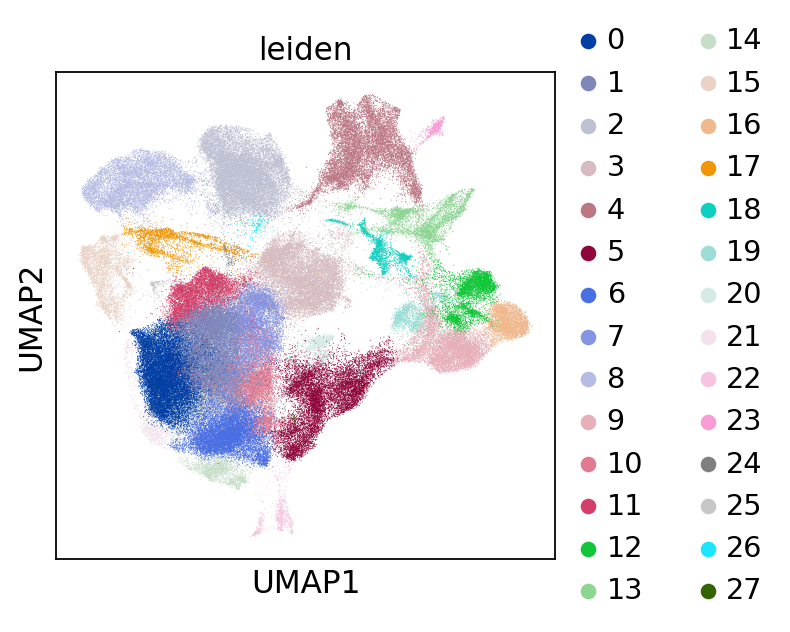

In [24]:
sc.pl.umap(eb_adata, color=['leiden'])

In [4]:
sc.tl.leiden(eb_adata, resolution=0.5, key_added="leiden_0.5")

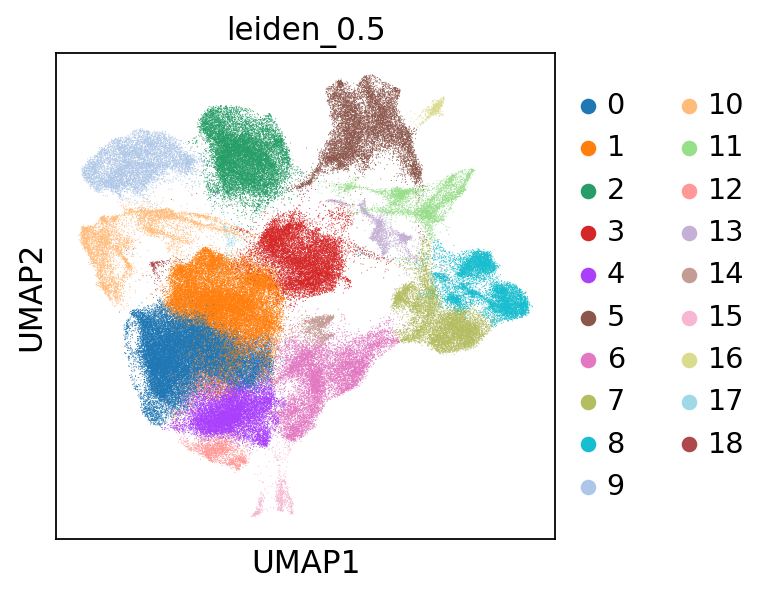

In [5]:
sc.pl.umap(eb_adata, color='leiden_0.5')

Subsample each cluster to have a comparable number of cells

In [6]:
eb_adata.obs['leiden_0.5'].value_counts()

0     28936
1     23685
2     14676
3     11823
4     11315
5     10594
6     10592
7      8579
8      8125
9      7596
10     5878
11     3888
12     3534
13     1843
14     1136
15      812
16      463
17      201
18      193
Name: leiden_0.5, dtype: int64

We'll shoot for 1K cells per cluster for now, or just the full cluster in the cases where the number of cells is fewer than 1K

In [7]:
in_tiny_clust = [c in ['15', '16', '17', '18'] for c in eb_adata.obs['leiden_0.5']]
tiny_clust_cells = eb_adata.obs_names[in_tiny_clust]

In [8]:
big_clusts = pd.DataFrame(eb_adata[np.invert(in_tiny_clust)].obs['leiden_0.5'])
big_clust_reps = big_clusts.groupby("leiden_0.5").sample(n=1000, random_state=0).index

In [9]:
subsample_cells = list(tiny_clust_cells) + list(big_clust_reps)

In [10]:
eb_adata_sub = eb_adata[subsample_cells]

Get the raw data back and save it

In [11]:
eb_adata_sub = eb_adata_sub.raw.to_adata()

In [12]:
eb_adata_sub.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.1ksubsampled.raw.h5ad")

Now we'll go back through the pipeline

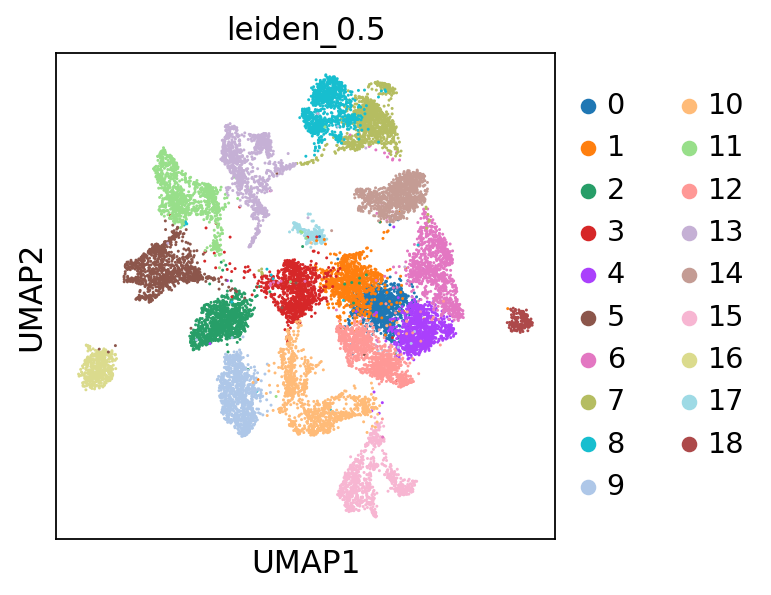

In [13]:
sc.pp.neighbors(eb_adata_sub, use_rep="X_scVI")
sc.tl.umap(eb_adata_sub)
sc.pl.umap(eb_adata_sub, color='leiden_0.5')

In [14]:
sc.tl.paga(eb_adata_sub, groups='leiden_0.5')

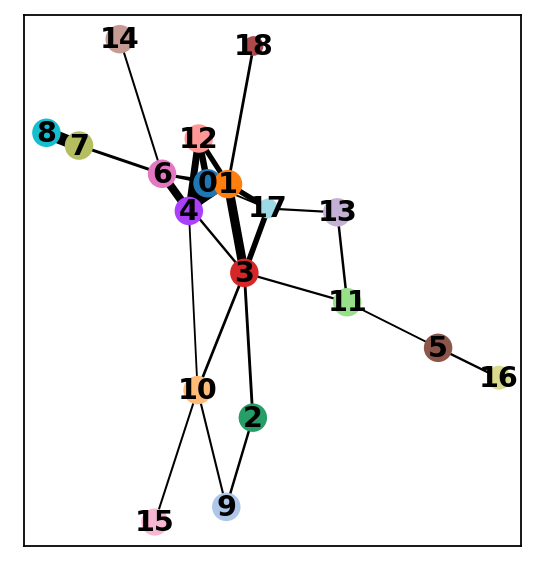

In [16]:
sc.pl.paga(eb_adata_sub, threshold=0.1)

This still doesn't match our expectation of three diverging germ layers

### Reprocessing subsampled dataset

In [17]:
sc.pp.highly_variable_genes(eb_adata_sub, n_top_genes=3000, flavor='seurat_v3', subset=True)

/home/jpopp/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [19]:
scvi.data.setup_anndata(eb_adata_sub, batch_key="library.prep.batch",
                        categorical_covariate_keys=['Collection.Date'])

INFO     Using batches from adata.obs["library.prep.batch"]                                  
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 16669 cells, 3000 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [20]:
vae = scvi.model.SCVI(eb_adata_sub, n_layers=2, n_latent=30,
                      gene_likelihood='nb')

In [21]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Set SLURM handle signals.


Epoch 400/400: 100%|██████████| 400/400 [09:30<00:00,  1.43s/it, loss=1.09e+03, v_num=1]


In [22]:
eb_adata_sub.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.1ksubsampled.scvi_input.h5ad")
vae.save("/project2/gilad/jpopp/ebQTL/data/scvi_models/scvi_nb_evensubsets_20211104", save_anndata=True)

In [2]:
eb_adata_sub = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/Lowpass.3seqbatches.merged.1ksubsampled.scvi_input.h5ad")
vae = scvi.model.SCVI.load("/project2/gilad/jpopp/ebQTL/data/scvi_models/scvi_nb_evensubsets_20211104")

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cat_covs']                                                                         
INFO     Successfully registered anndata object containing 16669 cells, 3000 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [6]:
eb_adata_sub.obsm["X_scVI_rerun"] = vae.get_latent_representation()

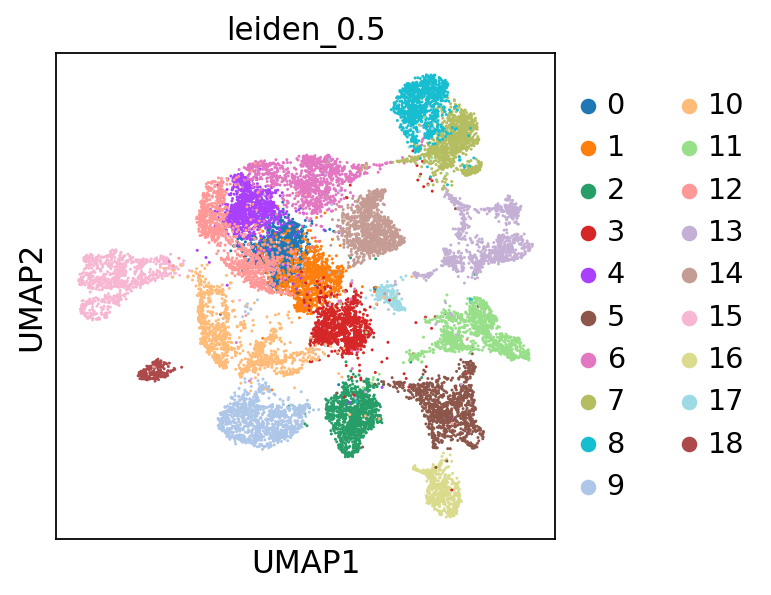

In [7]:
sc.pp.neighbors(eb_adata_sub, use_rep="X_scVI_rerun")
sc.tl.umap(eb_adata_sub)
sc.pl.umap(eb_adata_sub, color='leiden_0.5')

In [8]:
sc.tl.paga(eb_adata_sub, groups='leiden_0.5')

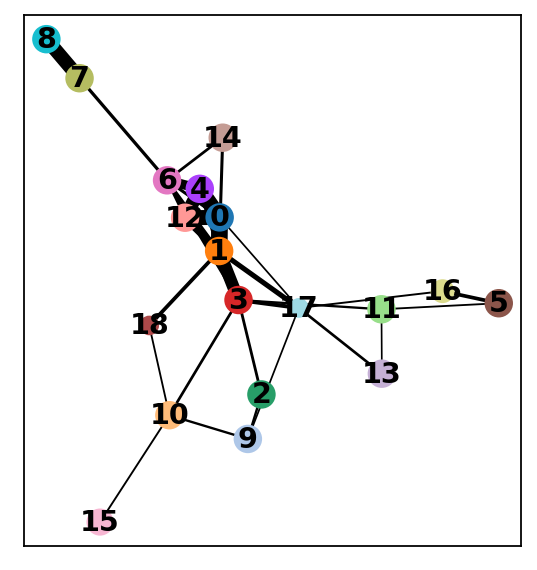

In [9]:
sc.pl.paga(eb_adata_sub, threshold=0.1)

It looks like we just might not have enough cells from the intermediate stages of the endoderm and mesoderm trajectories to piece all three germ layer trajectories together. The one last thing we could try would be to merge those early neural cells together into one cluster before subsampling, since those do still appear to be quite overrepresented in the dataset due to the breakdown into multiple clusters (which were each then subsampled).

## 